In [286]:
import sys
sys.path.append('../')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats

In [287]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

# Gamma family distributions

In [288]:
with open('gamma_d.stan', 'r') as file:
    print(file.read())

data {
    int alfa;
    int beta;
}

generated quantities {
    real theta = gamma_rng(alfa,beta);
    real theta_inv = inv_gamma_rng(alfa,beta);
}



In [289]:
model_prior = stan_utility.compile_model('gamma_d.stan')

Using cached StanModel


In [290]:
R=1000
data = dict(alfa = 10, beta = 5);
sim_ppc=model_prior.sampling(data=data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=100000)

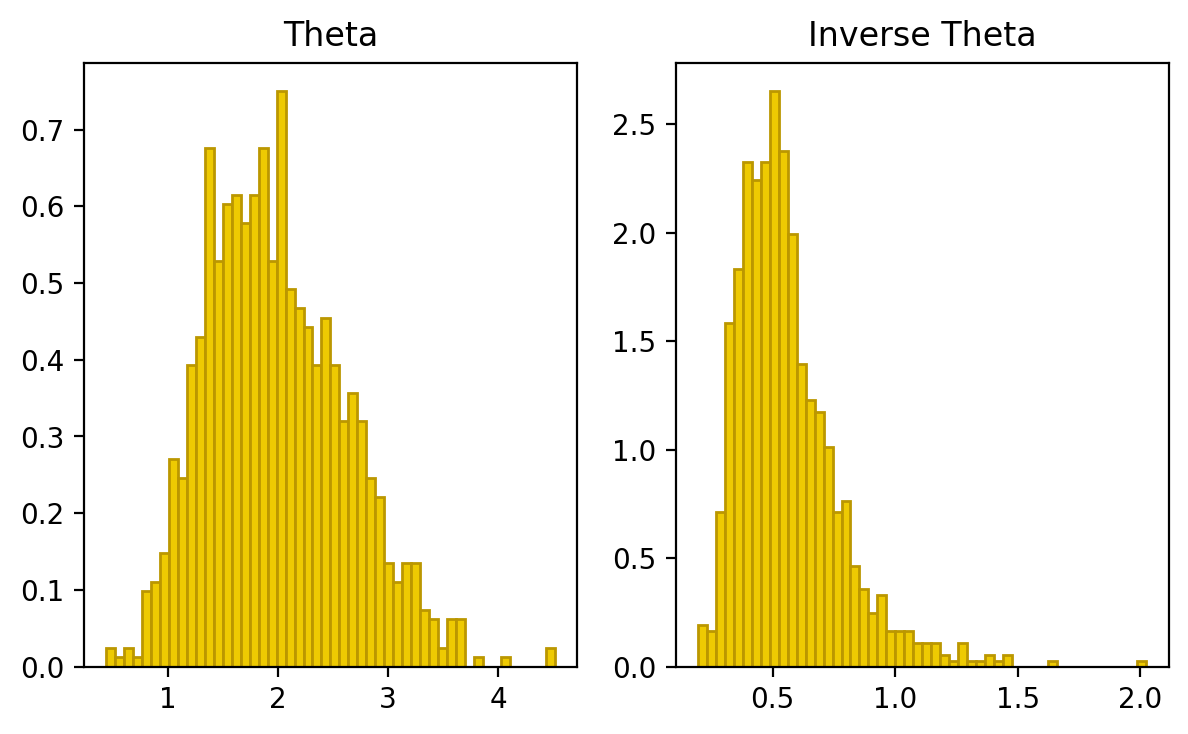

In [291]:
params = sim_ppc.extract()
theta = params['theta']
theta_inv = params['theta_inv']

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(theta,bins=50,color=dark,edgecolor=dark_highlight,density=True)
#x=np.linspace(0,1,100)
#ax1.plot(x,stats.uniform.pdf(x),color='black',linestyle='--')
#ax1.set_xticks([0,1])
#ax1.set_yticks([])
ax1.set_title('Theta')
#ax1.annotate('Prior',xy=(0.25,1),xytext=(0.05,1.5),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(theta_inv,color=dark,edgecolor=dark_highlight,density=True,bins=50)
#ax2.set_xticks([0,11])
#ax2.set_yticks([])
ax2.set_title('Inverse Theta')
plt.show()


In [292]:
with open('solver_4_gamma.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    //values between 5 and 10 with probabilty 98%, so 1% lesser than 5 and 1% greater than 10
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) -0.01; 
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) -0.99;
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of gamma params
  vector<lower=0>[2] theta;     // Target quantile
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i,1e-10, 1e-3, 1e3);

  print("alpha = ", y[1]);
  print("beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}



In [ ]:
tuning=stan_utility.compile_model('solver_4_gamma.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e96c2e4896f9dfbaaf71d14d5a02188 NOW.


In [ ]:
data2=dict(y_guess=np.array([1,0.1]),theta=np.array([5,10]))

In [ ]:
tuned = tuning.sampling(data=data2,
                          seed=100000,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)

alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])

print("Aplha: ",alpha,"Beta: ",beta)

In [ ]:
R=1000
data = dict(alfa = 46, beta = 6);
sim_ppc2=model_prior.sampling(data=data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=100000)

In [ ]:
params = sim_ppc2.extract()
theta = params['theta']
theta_inv = params['theta_inv']

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(theta,bins=50,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Theta')
ax2=axes[1]
ax2.hist(theta_inv,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('Inverse Theta')
plt.show()


In [ ]:
#We can observe above that parameters for gamma distribution were set properly 
#(Great part of it is situated between 5 and 10)

In [ ]:
#In this step we will find proper parameters 
#for inverse gamma distribution

In [ ]:
with open('solver_4_inv_gamma.stan', 'r') as file:
    print(file.read())

In [129]:
tuning_inv=stan_utility.compile_model('solver_4_inv_gamma.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_337bcd15716b7545e70b65ff08a4a56e NOW.


In [157]:
data3=dict(y_guess=np.array([1,2]),theta=np.array([10,5]))

In [159]:
tuned_inv = tuning_inv.sampling(data=data3,
                          seed=100000,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)

alpha = np.round(tuned_inv.extract()['alpha'][0])
beta = np.round(tuned_inv.extract()['beta'][0])

print("Aplha: ",alpha,"Beta: ",beta)

Aplha:  46.0 Beta:  314.0


In [160]:
R=1000
data = dict(alfa = 46, beta = 314);
sim_ppc2=model_prior.sampling(data=data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=100000)

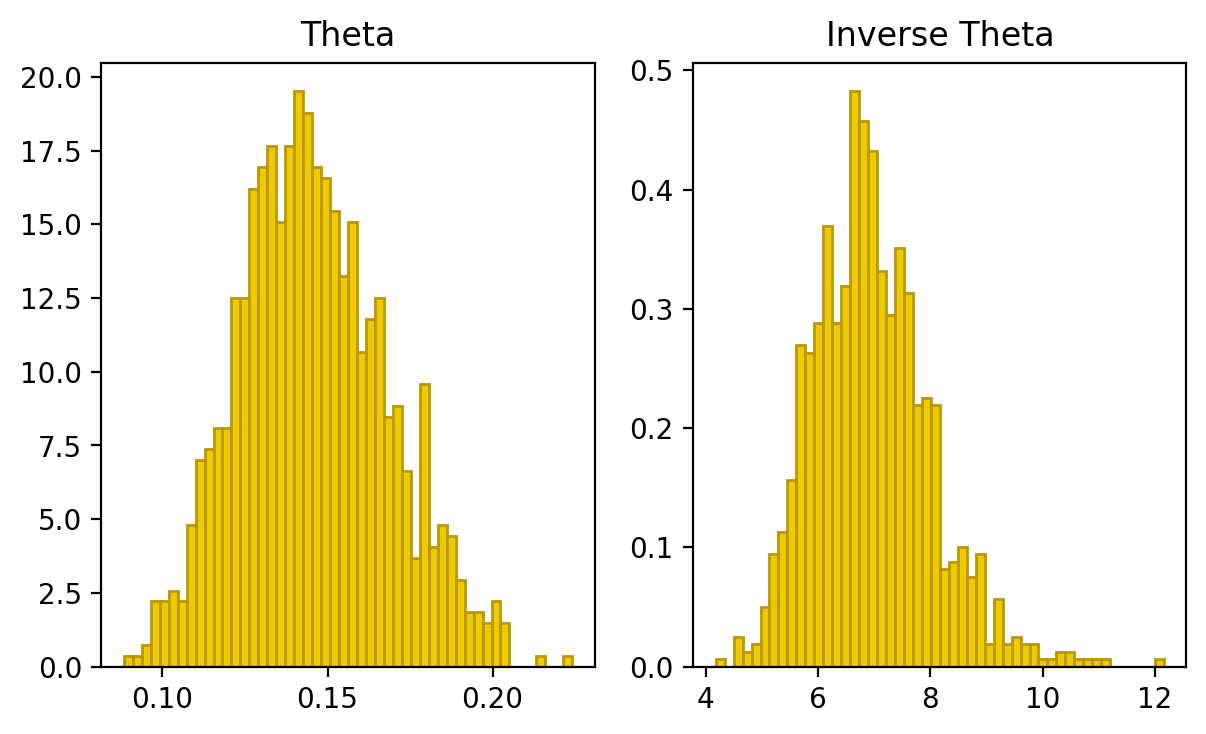

In [161]:
params = sim_ppc2.extract()
theta = params['theta']
theta_inv = params['theta_inv']

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(theta,bins=50,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Theta')
ax2=axes[1]
ax2.hist(theta_inv,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('Inverse Theta')
plt.show()


In [ ]:
#The distribution also seems to be correct (please have a look on figure
#on the right.)
#We can see also some similarity between (in shape and arguments):
#gamma distribution for Aplha:  46.0 Beta:  6.0 and inv. gamma for Aplha:  46.0 Beta:  314.0
#gamma distribution for Aplha:  46.0 Beta:  314.0 and inv. gamma for Aplha:  46.0 Beta:  6.0

# Negative Binomial distribution

In [263]:

with open('negative_b.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}


generated quantities {
    real<lower=0> y;
    y = neg_binomial_rng(alpha,beta);
}



In [264]:
with open('poisson.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> lambda;
}


generated quantities {
    real<lower=0> y;
    y = poisson_rng(lambda);
}



In [265]:
with open('negative_b_2.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}


generated quantities {
    real<lower=0> y;
    y = neg_binomial_2_rng(alpha,beta);
}



In [266]:
neg_bin_tun=stan_utility.compile_model('negative_b.stan')

Using cached StanModel


In [267]:
poisson_tun=stan_utility.compile_model('poisson.stan')

Using cached StanModel


In [268]:
neg_bin_tun2=stan_utility.compile_model('negative_b_2.stan')

Using cached StanModel


In [269]:
data = dict(alpha = 10, beta = 1)
neg_bin_sam = neg_bin_tun.sampling(data = data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)


In [270]:
poisson_samp = poisson_tun.sampling(data = {'lambda':10},algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)

In [271]:
data = dict(alpha = 10, beta = 1)
neg_bin2_sam = neg_bin_tun2.sampling(data = data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)


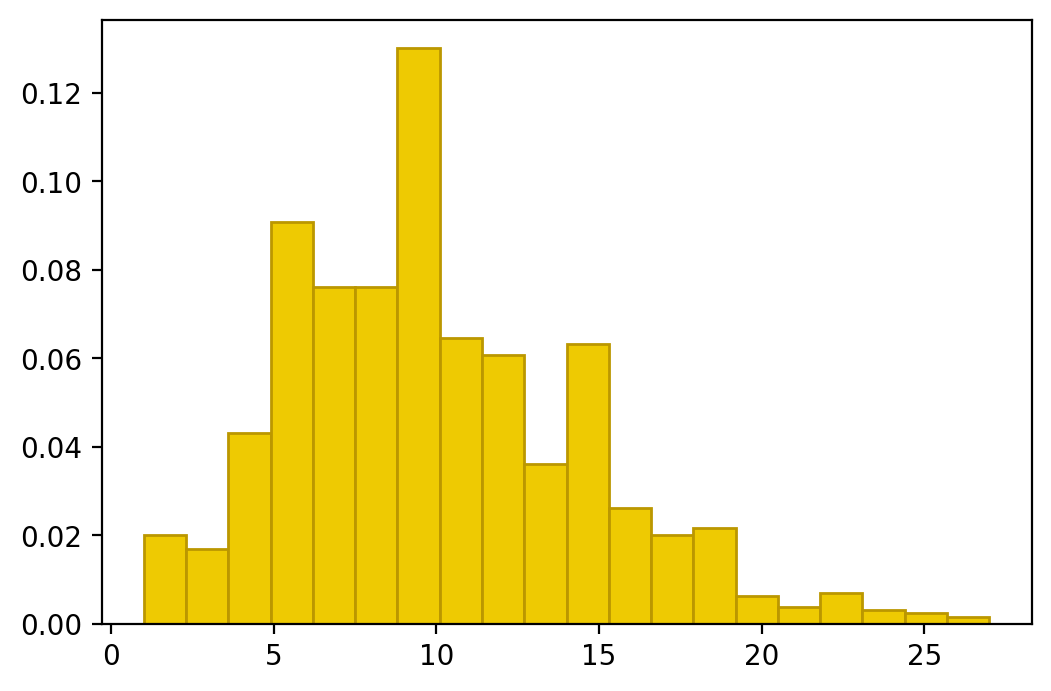

In [272]:
neg_bin_params = neg_bin_sam.extract()
poisson_params = poisson_samp.extract()
neg_bin2_params = neg_bin2_sam.extract()

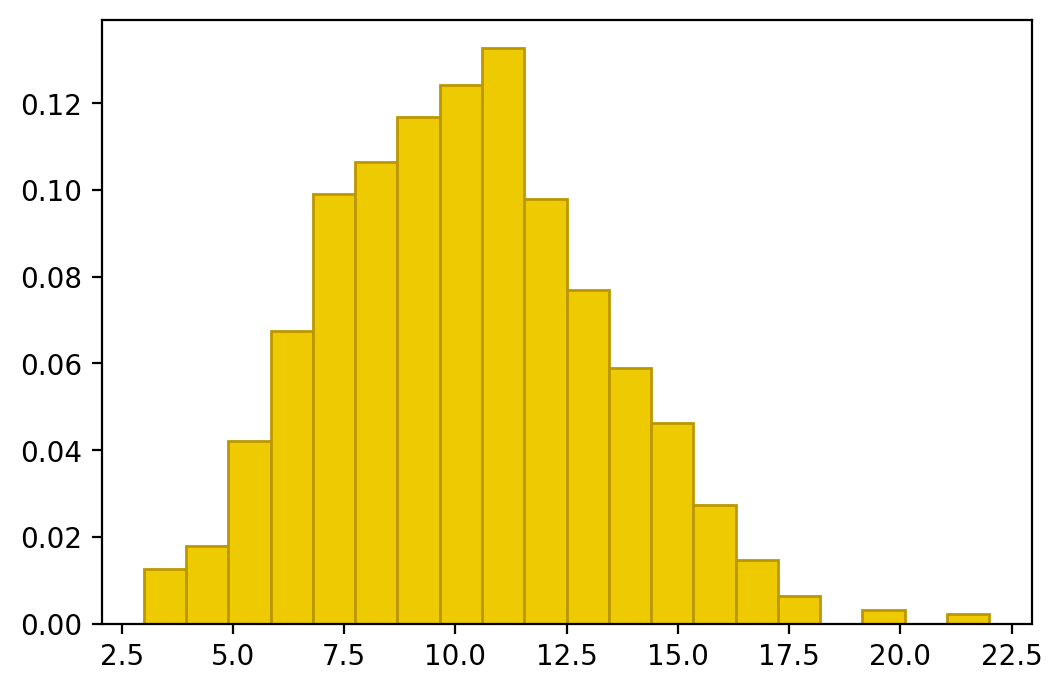

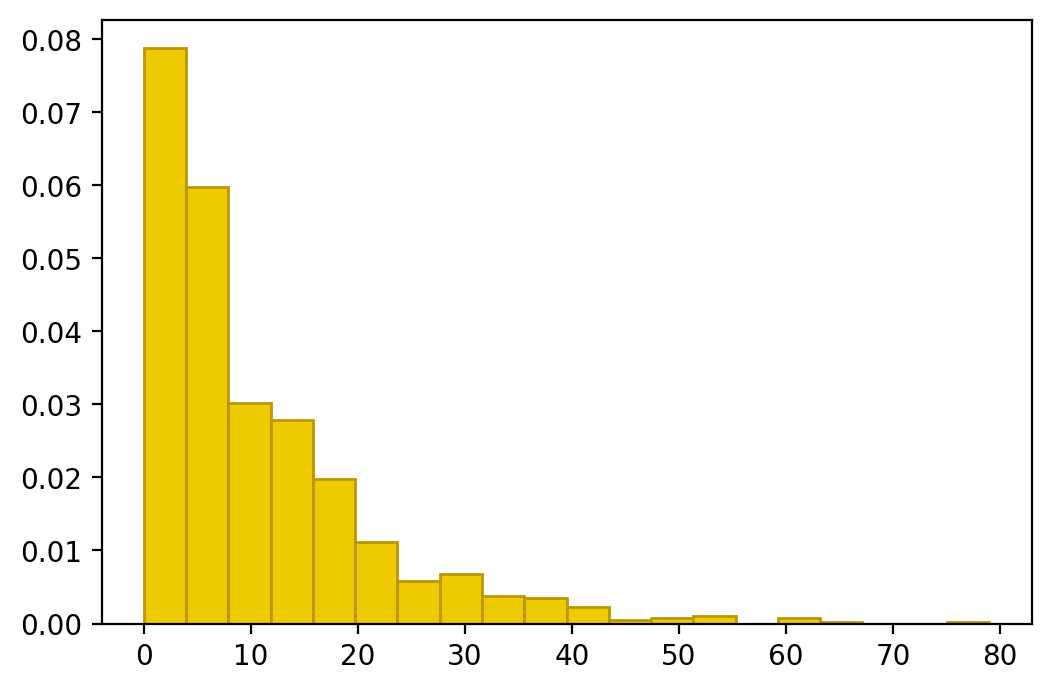

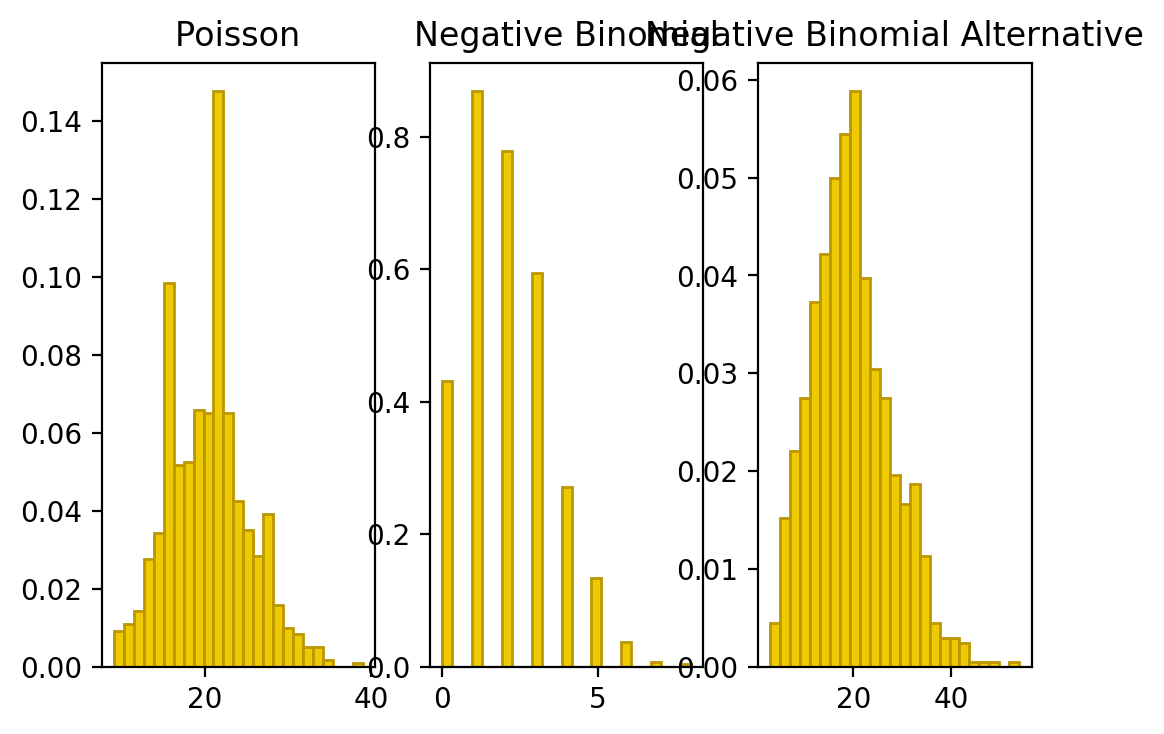

In [284]:
fig, axes = plt.subplots(1, 3)
ax1=axes[0]
ax1.hist(poisson_samp['y'],bins=25,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Poisson')
ax2=axes[1]
ax2.hist(neg_bin_sam['y'],color=dark,edgecolor=dark_highlight,density=True,bins=25)
ax2.set_title('Negative Binomial')
ax3=axes[2]
ax3.hist(neg_bin2_sam['y'],color=dark,edgecolor=dark_highlight,density=True,bins=25)
ax3.set_title('Negative Binomial Alternative')
plt.show()


In [285]:
# another example: alpha = 20, beta = 10

In [282]:
poisson_samp = poisson_tun.sampling(data = {'lambda':20},algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)
data = dict(alpha = 20, beta = 10)
neg_bin_sam = neg_bin_tun.sampling(data = data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)
data = dict(alpha = 20, beta = 10)
neg_bin2_sam = neg_bin_tun2.sampling(data = data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)

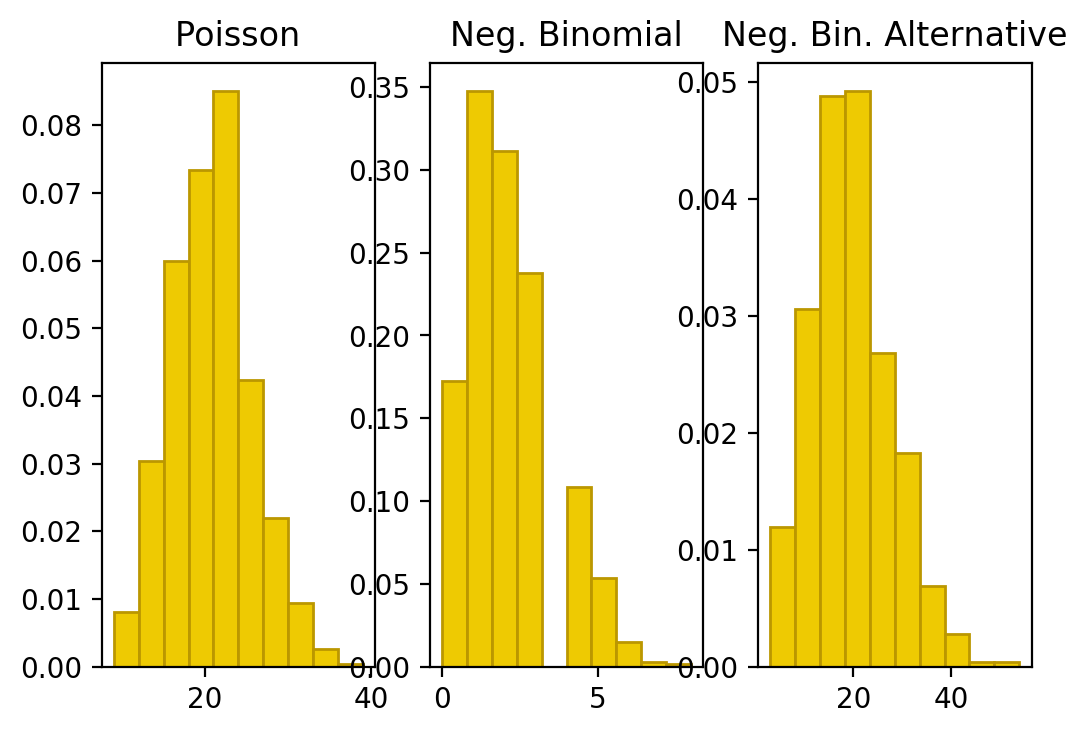

In [283]:
fig, axes = plt.subplots(1, 3)
ax1=axes[0]
ax1.hist(poisson_samp['y'],bins=10,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Poisson')

ax2=axes[1]
ax2.hist(neg_bin_sam['y'],color=dark,edgecolor=dark_highlight,density=True,bins=10)
ax2.set_title('Neg. Binomial')

ax3=axes[2]
ax3.hist(neg_bin2_sam['y'],color=dark,edgecolor=dark_highlight,density=True,bins=10)
ax3.set_title('Neg. Bin. Alternative')
plt.show()


In [279]:
# another example: alpha = 4, beta = 2

In [280]:
poisson_samp = poisson_tun.sampling(data = {'lambda':4},algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)
data = dict(alpha = 4, beta = 2)
neg_bin_sam = neg_bin_tun.sampling(data = data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)
data = dict(alpha = 4, beta = 2)
neg_bin2_sam = neg_bin_tun2.sampling(data = data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=100000)

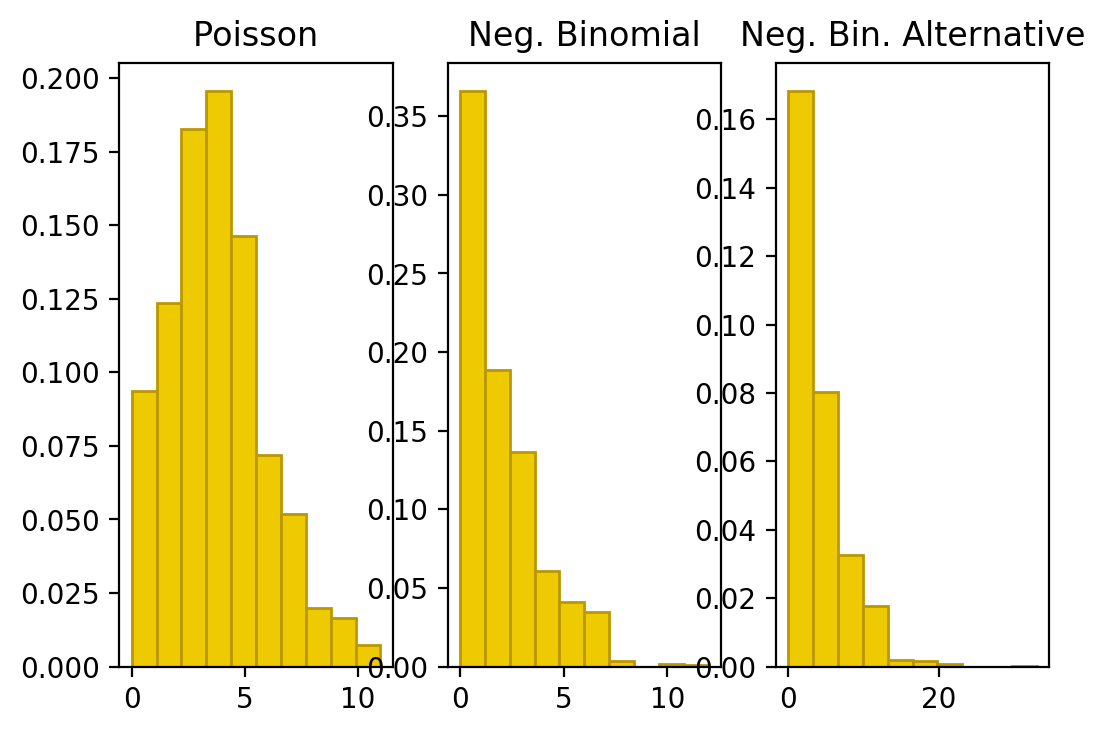

In [281]:
fig, axes = plt.subplots(1, 3)
ax1=axes[0]
ax1.hist(poisson_samp['y'],bins=10,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Poisson')

ax2=axes[1]
ax2.hist(neg_bin_sam['y'],color=dark,edgecolor=dark_highlight,density=True,bins=10)
ax2.set_title('Neg. Binomial')

ax3=axes[2]
ax3.hist(neg_bin2_sam['y'],color=dark,edgecolor=dark_highlight,density=True,bins=10)
ax3.set_title('Neg. Bin. Alternative')
plt.show()


In [ ]:
#Conclusions:
#We can see the difference between concentration and dispersion parametrizarion sample
#We should observe relation between poisson distribution and negative binomial
#consisting on variance difference. 
#While poisson distribution has variance equal to mean, equals alfa,
#negative binomial distribution has one equal to (alfa + (alfa^2)/beta)
#However it is difficult to recognize on presented figures.
